## **Occupancy Detection Data Set**

#### Описание данных - https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = './occupancy_data/datatraining.txt'

### Загрузка данных

In [6]:
data = pd.read_csv(TRAIN_DATASET_PATH)

### Изучение датасета

In [7]:
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18000,27.27200,426.00000,721.25000,0.00479,1
2,2015-02-04 17:51:59,23.15000,27.26750,429.50000,714.00000,0.00478,1
3,2015-02-04 17:53:00,23.15000,27.24500,426.00000,713.50000,0.00478,1
4,2015-02-04 17:54:00,23.15000,27.20000,426.00000,708.25000,0.00477,1
5,2015-02-04 17:55:00,23.10000,27.20000,426.00000,704.50000,0.00476,1


In [8]:
data.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
8139,2015-02-10 09:29:00,21.05000,36.09750,433.00000,787.25000,0.00558,1
8140,2015-02-10 09:29:59,21.05000,35.99500,433.00000,789.50000,0.00556,1
8141,2015-02-10 09:30:59,21.10000,36.09500,433.00000,798.50000,0.00560,1
8142,2015-02-10 09:32:00,21.10000,36.26000,433.00000,820.33333,0.00562,1
8143,2015-02-10 09:33:00,21.10000,36.20000,447.00000,821.00000,0.00561,1


data.info()

In [9]:
print(data.shape)

(8143, 7)


### Количественные переменные

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8143.00000,20.61908,1.01692,19.00000,19.70000,20.39000,21.39000,23.18000
Humidity,8143.00000,25.73151,5.53121,16.74500,20.20000,26.22250,30.53333,39.11750
Light,8143.00000,119.51937,194.75580,0.00000,0.00000,0.00000,256.37500,1546.33333
CO2,8143.00000,606.54624,314.32088,412.75000,439.00000,453.50000,638.83333,2028.50000
HumidityRatio,8143.00000,0.00386,0.00085,0.00267,0.00308,0.00380,0.00435,0.00648
Occupancy,8143.00000,0.21233,0.40898,0.00000,0.00000,0.00000,0.00000,1.00000


### Категориальные переменные

In [11]:
data.describe(include=['O']).T

,count,unique,top,freq
date,8143,8143,2015-02-05 07:51:00,1


In [12]:
# Целевая переменная
data['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

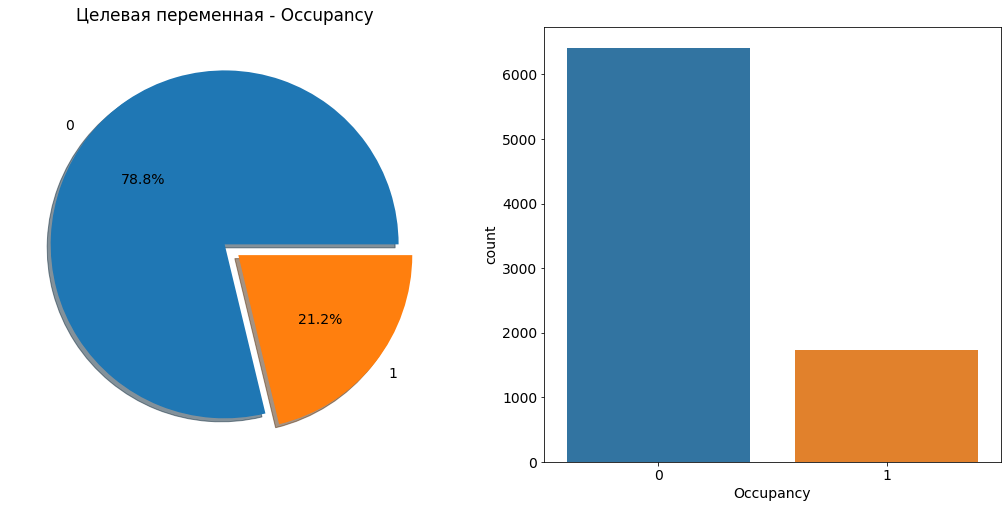

In [13]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
data['Occupancy'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Целевая переменная - Occupancy')
ax[0].set_ylabel('')
sns.countplot('Occupancy', data=data, ax=ax[1])
plt.show()

###  Обработка выбросов и пропусков

In [14]:
data.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

### Корреляция признаков

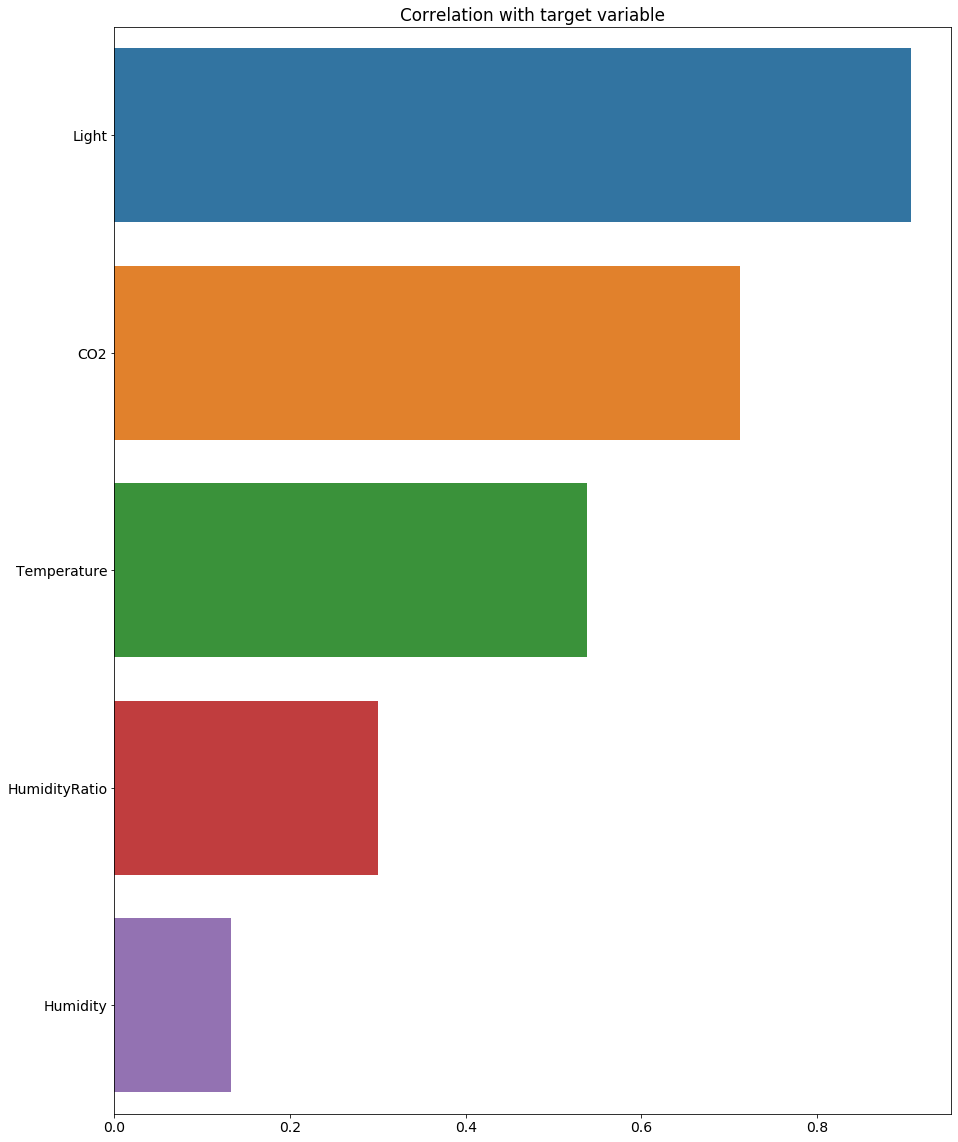

In [15]:
TARGET_NAME = 'Occupancy'

corr_with_target = data.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

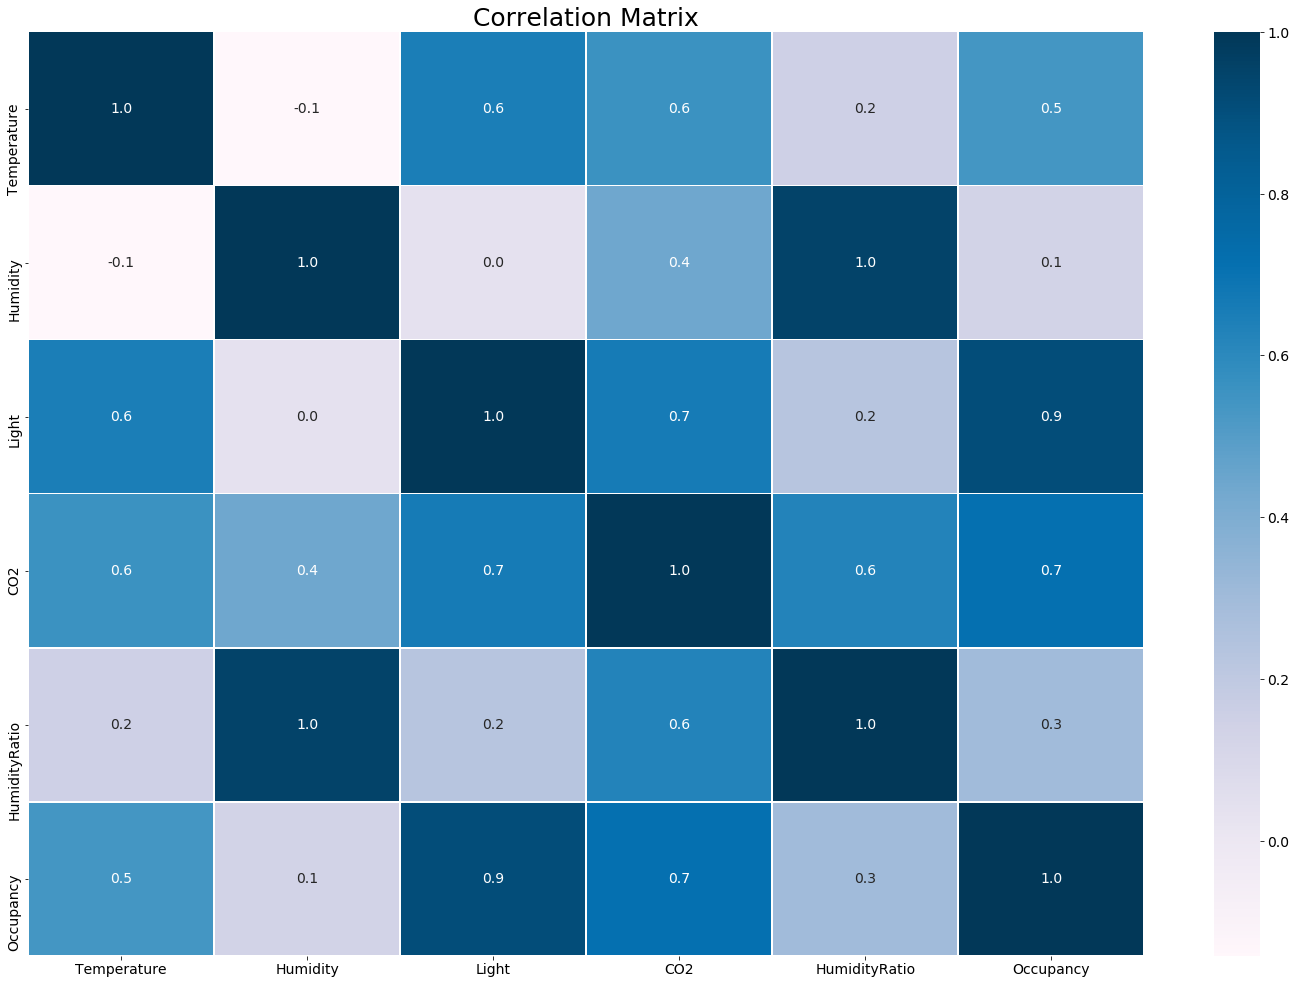

In [16]:
# Correlation Matrix
f, ax = plt.subplots(figsize = [25, 17])
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

### Feature engineering

In [17]:
data['date'].value_counts()

2015-02-05 07:51:00    1
2015-02-09 10:40:59    1
2015-02-06 16:53:59    1
2015-02-04 21:29:59    1
2015-02-08 20:12:00    1
                      ..
2015-02-10 04:27:59    1
2015-02-09 17:58:59    1
2015-02-07 21:10:59    1
2015-02-05 01:18:00    1
2015-02-09 01:06:00    1
Name: date, Length: 8143, dtype: int64

In [18]:
data['date'].describe()

count                    8143
unique                   8143
top       2015-02-05 07:51:00
freq                        1
Name: date, dtype: object

In [19]:
time_cols = [col for col in data.columns if data[col].dtype=='object']
    
for col in time_cols:
        data[col] = pd.to_datetime(data[col], yearfirst=True)
        

data['hour'] = data.date.map(lambda x: x.hour)
data['morning'] = data.hour.map(lambda x: 1 if x<=11 else 0)
data['day'] = data.hour.map(lambda x: 1 if 12 <= x <= 18 else 0)
data['evening'] = data.hour.map(lambda x: 1 if 18 <= x <= 24 else 0)

data.drop(['date'], axis=1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    8143 non-null   float64
 1   Humidity       8143 non-null   float64
 2   Light          8143 non-null   float64
 3   CO2            8143 non-null   float64
 4   HumidityRatio  8143 non-null   float64
 5   Occupancy      8143 non-null   int64  
 6   hour           8143 non-null   int64  
 7   morning        8143 non-null   int64  
 8   day            8143 non-null   int64  
 9   evening        8143 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 1019.8 KB


### Подготовка признаков

In [21]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [22]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(silent=True)

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

Проверяем качество

In [23]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:
f1: 100.00%
roc: 100.00%
recall: 100.00%
precision: 100.00%


In [24]:
# Classification results before feature engineering:
# f1: 97.55%
# roc: 98.52%
# recall: 97.93%
# precision: 97.18%

### PU learning

In [25]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 540/2160 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [26]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    7603
 1     540
Name: class_test, dtype: int64


* We now have just 153 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col 4 still holds the actual label

In [27]:
mod_data.head(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,hour,morning,day,evening,class_test
1,23.18000,27.27200,426.00000,721.25000,0.00479,1,17,0,1,0,-1
2,23.15000,27.26750,429.50000,714.00000,0.00478,1,17,0,1,0,-1
3,23.15000,27.24500,426.00000,713.50000,0.00478,1,17,0,1,0,-1
4,23.15000,27.20000,426.00000,708.25000,0.00477,1,17,0,1,0,-1
5,23.10000,27.20000,426.00000,704.50000,0.00476,1,17,0,1,0,-1
6,23.10000,27.20000,419.00000,701.00000,0.00476,1,17,0,1,0,-1
7,23.10000,27.20000,419.00000,701.66667,0.00476,1,17,0,1,0,-1
8,23.10000,27.20000,419.00000,699.00000,0.00476,1,17,0,1,0,-1
9,23.10000,27.20000,419.00000,689.33333,0.00476,1,17,0,1,0,-1
10,23.07500,27.17500,419.00000,688.00000,0.00475,1,18,0,1,1,-1


Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [28]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [29]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(540, 11) (540, 11)


In [30]:
model = CatBoostClassifier(silent=True)

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 100.00%
roc: 100.00%
recall: 100.00%
precision: 100.00%


### 2. probabilistic approach

* The training set will be divided into a fitting-set that will be used to fit the estimator in order to estimate P(s=1|X) and a held-out set of positive samples that will be used to estimate P(s=1|y=1)

In [31]:
def fit_PU_estimator(X,y, hold_out_ratio, estimator):
    
    # find the indices of the positive/labeled elements
    assert (type(y) == np.ndarray), "Must pass np.ndarray rather than list as y"
    positives = np.where(y == 1.)[0] 
    # hold_out_size = the *number* of positives/labeled samples 
    # that we will use later to estimate P(s=1|y=1)
    hold_out_size = int(np.ceil(len(positives) * hold_out_ratio))
    np.random.shuffle(positives)
    # hold_out = the *indices* of the positive elements 
    # that we will later use  to estimate P(s=1|y=1)
    hold_out = positives[:hold_out_size] 
    # the actual positive *elements* that we will keep aside
    X_hold_out = X[hold_out] 
    # remove the held out elements from X and y
    X = np.delete(X, hold_out,0) 
    y = np.delete(y, hold_out)
    # We fit the estimator on the unlabeled samples + (part of the) positive and labeled ones.
    # In order to estimate P(s=1|X) or  what is the probablity that an element is *labeled*
    estimator.fit(X, y)
    # We then use the estimator for prediction of the positive held-out set 
    # in order to estimate P(s=1|y=1)
    hold_out_predictions = estimator.predict_proba(X_hold_out)
    #take the probability that it is 1
    hold_out_predictions = hold_out_predictions[:,1]
    # save the mean probability 
    c = np.mean(hold_out_predictions)
    return estimator, c

def predict_PU_prob(X, estimator, prob_s1y1):
    predicted_s = estimator.predict_proba(X)
    predicted_s = predicted_s[:,1]
    return predicted_s / prob_s1y1

* test the PU estimation approach

In [32]:
predicted = np.zeros(len(x_data))
learning_iterations = 24
for index in range(learning_iterations):
    pu_estimator, probs1y1 = fit_PU_estimator(x_data, y_labeled, 0.2, CatBoostClassifier(silent=True))
    predicted += predict_PU_prob(x_data, pu_estimator, probs1y1)
    if(index%4 == 0): 
        print(f'Learning Iteration::{index}/{learning_iterations} => P(s=1|y=1)={round(probs1y1,2)}')

Learning Iteration::0/24 => P(s=1|y=1)=0.2
Learning Iteration::4/24 => P(s=1|y=1)=0.21
Learning Iteration::8/24 => P(s=1|y=1)=0.21
Learning Iteration::12/24 => P(s=1|y=1)=0.19
Learning Iteration::16/24 => P(s=1|y=1)=0.2
Learning Iteration::20/24 => P(s=1|y=1)=0.21


* compare the performance of the predictions of the PU approacj (y_predict) with the actuall original classes (y_positive) that we have saved aside

In [33]:
y_predict = [1 if x > 0.01 else 0 for x in (predicted/learning_iterations)]
evaluate_results(y_positive, y_predict)

Classification results:
f1: 98.61%
roc: 99.49%
recall: 100.00%
precision: 97.25%
